In [185]:
import pandas as pd
import numpy as np
import plotly as py
import plotly.express as px
import numpy as np
import re
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from collections import Counter
from nltk import word_tokenize
import nltk
import spacy
from spacy import displacy
import seaborn as sns
import string
import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import textstat
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn import svm
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquelineskunda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [186]:
df_charlines = pd.read_csv("/Users/jacquelineskunda/Documents/GitHub/696/Milestone2/Data/Seasons_Episodes/output/charlines_df.csv")

In [187]:
df_charlines.loc[df_charlines["Spoke_Before"].isnull(),'Spoke_Before'] = df_charlines['Character_Fix']

In [188]:
df_charlines.tail(3)

,Unnamed: 0,index,Character,Dialog,Season,Episode,Fix Name,Character_Fix,Spoke_Before,Character_Keep,Length Dialog
6065,39,270,CLAUDIA,Where did you see it last?,2,9,True,CLAUDIA,SUSAN,Keep,26
6066,39,270,CLAUDIA,What's in there that's so important anyway? ...,2,9,True,CLAUDIA,SUSAN,Keep,132
6067,39,270,CLAUDIA,That's your ride! Dusty??? The bag from Melva...,2,9,True,CLAUDIA,SUSAN,Keep,75


In [189]:
df_charlines.dropna(subset=['Dialog'],inplace = True)

In [190]:
df_charlines.drop(['Unnamed: 0'], axis=1, inplace = True)
df_charlines.shape

(5457, 10)

In [191]:
df_charlines['Dialog_Check'] = df_charlines['Dialog'].apply(lambda x: x.isdigit())

In [192]:
df_charlines['Remove_Lines'] = df_charlines['Dialog'].apply(lambda x: True if "1/" in x else False)

In [193]:
df_charlines2 = df_charlines[df_charlines['Remove_Lines']==False].copy()

In [194]:
df_charlines2.shape

(5451, 12)

In [195]:
df = df_charlines2.copy()
df['Dialog_clean'] = df['Dialog'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['Dialog_tokenized'] = df['Dialog_clean'].apply(lambda x: word_tokenize(x.strip().lower()))
df['Dialog_Count'] = df['Dialog_tokenized'].apply(lambda x: len(x))
LinesSpokeDf = df.groupby(['Character_Fix'])["Dialog_Count"].sum().reset_index()
LinesSpokeDf = LinesSpokeDf.sort_values(by=["Dialog_Count"], ascending = False)

In [196]:
_20df = LinesSpokeDf.head(20)

In [197]:
top20chars = list(_20df.Character_Fix.unique())

In [198]:
gender = pd.read_csv('/Users/jacquelineskunda/Documents/GitHub/696/Milestone2/Data/Seasons_Episodes/output/gender_st.csv')

In [199]:
df_show = df[['Character_Fix','Season',"Episode","Dialog"]].copy()

In [200]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def polarity(text):
    pol = sid.polarity_scores(text)
    return pol

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquelineskunda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [201]:
#Function to preprocess text
def cleaner(text):
  	# Create doc object
    doc = nlp(text)
    
    # Generate lemmas and lower case and remove punctuation
    lemmas = [token.lemma_.lower() for token in doc if not token.is_punct\
              and token.is_alpha]
    #token.is_stop == False 
    # Remove stopwords, extra characters like numbers (second check)
    #all_lemmas = [lemma for lemma in lemmas if lemma.isalpha]
    
    return " ".join(lemmas)

In [202]:
df_show['token_lemma'] = df_show['Dialog'].apply(cleaner)

In [203]:
df_show.tail(3)

,Character_Fix,Season,Episode,Dialog,token_lemma
6065,CLAUDIA,2,9,Where did you see it last?,where do you see it last
6066,CLAUDIA,2,9,What's in there that's so important anyway? ...,what in there that so important anyway you loo...
6067,CLAUDIA,2,9,That's your ride! Dusty??? The bag from Melva...,that your ride dusty the bag from melvald upen...


In [204]:
RANDOM_SEED = 655

In [205]:
df_show['length'] = df_show.token_lemma.apply(lambda x: len(x))

In [206]:
df_show2= df_show.explode(column='token_lemma').dropna(subset=['token_lemma'])
#adding grade leve of spoken lines and difficulty
df_show2['grade'] = df_show2.Dialog.apply(lambda x: textstat.flesch_kincaid_grade(x))
df_show2['difficulty'] = df_show2.Dialog.apply(lambda x: textstat.difficult_words(x))

#adding the compound score on again but with the token lemma
df_show2['polarity'] = df_show2['token_lemma'].apply(polarity)  #polarity checking
df_show2['compound']  = df_show2['polarity'].apply(lambda score_dict: score_dict['compound'])

df_show2['sentiment'] = df_show2['compound'].apply(lambda x: "Positive" if x>=0.5 \
                                                     else("Negative" if x<=-0.5 \
                                                     else "Neutral"))
#filtering those who spoke less than 3 works
df_show2['length_spk'] = df_show2['token_lemma'].apply(lambda x: len(x.split()))
df_show2 = df_show2[df_show2['length_spk'] >3].copy()


In [207]:
#filtering characters who appeared 2 times or less in the show
check_appearance = df_show2.groupby(['Character_Fix'])['Character_Fix'].count()
appearance = pd.DataFrame({'Character_Fix':check_appearance.index,'Num':check_appearance.values})

In [208]:
appearance.sort_values(by='Num',inplace = True)

In [209]:
df_show2 = df_show2.merge(appearance, how="left", on ='Character_Fix').copy()
df_show2 = df_show2[df_show2['Num']> 2].copy()

In [210]:
#Top20 Characters Only
df_show2['TOP_20'] = df_show2['Character_Fix'].apply(lambda x: \
                                True if x in top20chars else False)

df_show2 = df_show2[df_show2['TOP_20']==True].copy()

In [211]:
train_df, test_df = np.split(df_show2.sample(frac=1, random_state=RANDOM_SEED), 
                       [int(.8*len(df_show2))])
print(len(train_df), len(test_df))

vectorizer = TfidfVectorizer(min_df = 20, stop_words = 'english')
X_train = vectorizer.fit_transform(train_df.token_lemma)
X_test = vectorizer.transform(test_df.token_lemma)

y_train=train_df['Character_Fix'].values
y_test=test_df['Character_Fix'].values

df_tf = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
df_tf_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

tr_df = train_df.reset_index()
tr_df_test = test_df.reset_index()

train_w_feat = pd.concat([df_tf,tr_df],axis=1)
test_w_feat = pd.concat([df_tf_test,tr_df_test],axis=1)

train_w_feat.drop(['Dialog','token_lemma','index'], axis=1, inplace=True)
test_w_feat.drop(['Dialog','token_lemma','index'], axis=1, inplace=True)

train_w_features = pd.merge(train_w_feat, gender, on="Character_Fix",how='left')
test_w_features = pd.merge(test_w_feat, gender, on="Character_Fix",how='left')

train_w_features3 = train_w_features.drop(['Character_Fix'], axis=1).copy()
test_w_features3 = test_w_features.drop(['Character_Fix'], axis=1).copy()

train_w_features3['Gender'].replace(['Female ', 'Female','Male','Male ','Neutral'],
                        [1, 1,2,2,0], inplace=True)
test_w_features3['Gender'].replace(['Female ', 'Female','Male','Male ','Neutral'],
                        [1, 1,2,2,0], inplace=True)



3360 841


In [212]:
train_w_features3.drop(['polarity'], axis=1, inplace = True)
test_w_features3.drop(['polarity'], axis=1, inplace = True)
train_w_features3['sentiment'] = train_w_features3['compound'].apply(lambda x: "Positive" if x>=0.5 \
                                                     else("Negative" if x<=-0.5 \
                                                     else "Neutral"))
test_w_features3['sentiment'] = test_w_features3['compound'].apply(lambda x: "Positive" if x>=0.5 \
                                                     else("Negative" if x<=-0.5 \
                                                     else "Neutral"))

In [213]:
train_w_features3['sentiment'].replace(['Negative', 'Neutral','Positive'],
                        [-1,0,1], inplace=True)
test_w_features3['sentiment'].replace(['Negative', 'Neutral','Positive'],
                        [-1,0,1], inplace=True)

In [214]:
train_w_features3.isna().values.any()

False

In [257]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
# create model
cv_scores = []
model_name = []

In [258]:
# create model
model_rf = RandomForestClassifier(n_estimators= 500, 
                                           min_samples_split= 20, 
                                           min_samples_leaf= 1,
                                           max_features= 'sqrt', 
                                           max_depth= 30, 
                                           criterion= 'gini',
                                           n_jobs = -1,
                              random_state=RANDOM_SEED).fit(train_w_features3, y_train)
# evaluate model
scores_rf = cross_val_score(model_rf, train_w_features3, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_rf), std(scores_rf)))
print('All Accuracy Scores: %.3f',scores_rf)
cv_scores.append(scores_rf)
model_name.append('Random Forest Tuned')

Accuracy: 0.849 (0.019)
All Accuracy Scores: %.3f [0.81547619 0.83630952 0.84821429 0.86309524 0.87202381 0.82142857
 0.8422619  0.85119048 0.86309524 0.87202381]


In [259]:
# create model
model_rf_notune = RandomForestClassifier(n_estimators=100,
                              max_features='sqrt',
                              random_state=RANDOM_SEED).fit(train_w_features3, y_train)
# evaluate model
scores_rf2 = cross_val_score(model_rf_notune, train_w_features3, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_rf2), std(scores_rf2)))
print('All Accuracy Scores:',scores_rf2)
cv_scores.append(scores_rf2)
model_name.append('Random Forest')

Accuracy: 0.903 (0.014)
All Accuracy Scores: [0.89583333 0.88392857 0.89880952 0.93154762 0.90178571 0.88690476
 0.9077381  0.88988095 0.91369048 0.91964286]


In [260]:
# create model
model_svm = svm.SVC(kernel = 'linear', gamma = 0.01, degree = 1, C = 1,
                              random_state=RANDOM_SEED,).fit(train_w_features3, y_train)
# evaluate model
scores_svm = cross_val_score(model_svm, train_w_features3, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_svm), std(scores_svm)))
print('All Accuracy Scores:',scores_svm)
cv_scores.append(scores_svm)
model_name.append('LinearSVM')

Accuracy: 1.000 (0.000)
All Accuracy Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [261]:
# create model
model_lg = LogisticRegression(max_iter = 500,
                              random_state=RANDOM_SEED,
                              solver = 'liblinear',penalty= 'l1',
                              C = 1.0).fit(train_w_features3, y_train)
# evaluate model
scores_lg = cross_val_score(model_lg, train_w_features3, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores_lg), std(scores_lg)))
print('All Accuracy Scores:',scores_lg)
cv_scores.append(scores_lg)
model_name.append('Logistic Regression')

Accuracy: 0.825 (0.014)
All Accuracy Scores: [0.81547619 0.81547619 0.83333333 0.84821429 0.83333333 0.80952381
 0.8452381  0.83035714 0.80357143 0.81845238]


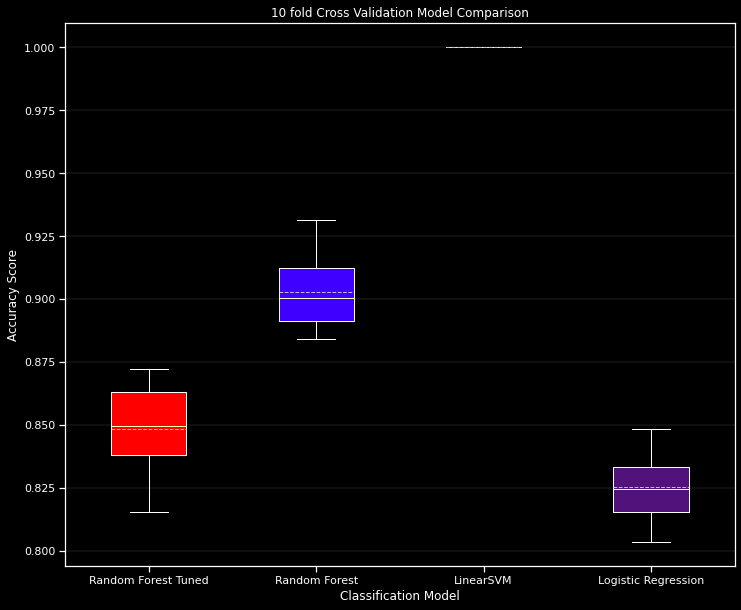

In [286]:
import matplotlib.pyplot as plt
# Plotting the cross-validated box plot 
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(12,10))

#plt.suptitle('Supervised Learning Model Comparison')
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
box = ax.boxplot(cv_scores,labels = model_name,
                 meanline=True, showmeans=True, patch_artist=True)
#ax.set_xticklabels(model_name)
plt.rcParams['image.cmap']='magma'
plt.grid(False)
ax.grid(color='white', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})
#figure.facecolor':'black
plt.title("10 fold Cross Validation Model Comparison",
          {'fontsize': 12,'color': "white"})
plt.rcParams['savefig.facecolor']='black'
ax.set_xlabel('Classification Model')
ax.set_ylabel('Accuracy Score')
plt.rcParams['lines.color'] = 'r'
#plt.xticks(rotation=10)

colors = ['#FF0000', '#3F00FF',
          '#FFFF00', '#51127c']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.show()

In [287]:
data_tuples = list(zip(model_name,cv_scores))
comp_df = pd.DataFrame(data_tuples, columns=['Model Name','Accuracy Scores'])

In [297]:
comp_df = comp_df.explode('Accuracy Scores').reset_index(drop=True)

In [298]:
comp_df_fin = comp_df.groupby(['Model Name'],as_index=False).agg(
                      {'Accuracy Scores':['mean','std']})

In [300]:
comp_df_fin.columns = ['Model Name','Mean Accuracy','Std Accuracy']

In [302]:
comp_df_fin.to_csv("10cvalidmetrics.csv")